### Import libraries and load data
We load and merge multiple CSV files containing football match data. We then create a binary target variable Over2.5 which is 1 if the total goals in the match exceed 2.5.

In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

# Load multiple seasons into a single DataFrame
file_paths = ['19-20.csv', '20-21.csv', '22-23.csv', '23-24.csv', '24-25.csv']
df = pd.concat([pd.read_csv(f) for f in file_paths], ignore_index=True)

# Parse dates and clean up
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')
df.dropna(subset=['Date'], inplace=True)
df.sort_values('Date', inplace=True)

# Add target variable: Over 2.5 goals
df['TotalGoals'] = df['FTHG'] + df['FTAG']
df['Over2.5'] = (df['TotalGoals'] > 2.5).astype(int)

### Adding functions to calculate team stats
This function calculates the recent form (total points in last 5 matches) of a given team before a specific date.

In [3]:
def compute_form(team, date, df):
    past = df[(df['Date'] < date) & ((df['HomeTeam'] == team) | (df['AwayTeam'] == team))].sort_values('Date').tail(5)
    if len(past) < 5: return 0
    points = 0
    for _, row in past.iterrows():
        if row['HomeTeam'] == team:
            if row['FTR'] == 'H': points += 3
            elif row['FTR'] == 'D': points += 1
        elif row['AwayTeam'] == team:
            if row['FTR'] == 'A': points += 3
            elif row['FTR'] == 'D': points += 1
    return points

Calculates averages for goals scored, goals conceded, and win rate for a team before a specific date

In [4]:
def compute_team_averages(team, date, df):
    past = df[(df['Date'] < date) & ((df['HomeTeam'] == team) | (df['AwayTeam'] == team))]
    if len(past) < 5: return None
    gs = gc = wins = 0
    for _, row in past.iterrows():
        if row['HomeTeam'] == team:
            gs += row['FTHG']
            gc += row['FTAG']
            if row['FTR'] == 'H': wins += 1
        elif row['AwayTeam'] == team:
            gs += row['FTAG']
            gc += row['FTHG']
            if row['FTR'] == 'A': wins += 1
    matches = len(past)
    return {
        'avg_scored': gs / matches,
        'avg_conceded': gc / matches,
        'win_rate': wins / matches
    }

### Feature engineering 
Builds a clean dataset with pre-match statistics for each team (form, scoring rate, etc.), ensuring only past data is used.

In [5]:
full_data = []
for _, row in df.iterrows():
    date = row['Date']
    home = row['HomeTeam']
    away = row['AwayTeam']

    home_stats = compute_team_averages(home, date, df)
    away_stats = compute_team_averages(away, date, df)
    if home_stats is None or away_stats is None:
        continue

    home_form = compute_form(home, date, df)
    away_form = compute_form(away, date, df)

    full_data.append({
        'Date': date,
        'HomeTeam': home,
        'AwayTeam': away,
        'HomeForm': home_form,
        'AwayForm': away_form,
        'HomeAvgGoalsScored': home_stats['avg_scored'],
        'HomeAvgGoalsConceded': home_stats['avg_conceded'],
        'HomeWinRate': home_stats['win_rate'],
        'AwayAvgGoalsScored': away_stats['avg_scored'],
        'AwayAvgGoalsConceded': away_stats['avg_conceded'],
        'AwayWinRate': away_stats['win_rate'],
        'FTHG': row['FTHG'],
        'FTAG': row['FTAG'],
        'TotalGoals': row['TotalGoals'],
        'Over2.5': row['Over2.5']
    })

full_df = pd.DataFrame(full_data)
full_df.sort_values('Date', inplace=True)

### Define features and walk-forward test setup
Defining input features and prepare the variables needed to store results. Then we used a scaler to normalize the data before training.

In [6]:
features = [
    'HomeForm', 'AwayForm',
    'HomeAvgGoalsScored', 'HomeAvgGoalsConceded',
    'AwayAvgGoalsScored', 'AwayAvgGoalsConceded',
    'HomeWinRate', 'AwayWinRate'
]

min_train_size = 500
preds, trues, probas = [], [], []
dates, home_teams, away_teams = [], [], []
fthg_list, ftag_list, total_goals = [], [], []

scaler = StandardScaler()

### Walk-forward validation loop
This loop simulates real-time prediction by always training on past data and testing on the next unseen match. Each prediction is stored for later evaluation.

In [7]:
for i in range(min_train_size, len(full_df)):
    train_df = full_df.iloc[:i]
    test_row = full_df.iloc[i:i+1]

    X_train = scaler.fit_transform(train_df[features])
    y_train = train_df['Over2.5']
    X_test = scaler.transform(test_row[features])
    y_test = test_row['Over2.5'].values[0]

    model = XGBClassifier(eval_metric='logloss', random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)[0]
    y_prob = model.predict_proba(X_test)[0][1]

    # Store test match info
    preds.append(y_pred)
    trues.append(y_test)
    probas.append(y_prob)
    dates.append(test_row['Date'].values[0])
    home_teams.append(test_row['HomeTeam'].values[0])
    away_teams.append(test_row['AwayTeam'].values[0])
    fthg_list.append(test_row['FTHG'].values[0])
    ftag_list.append(test_row['FTAG'].values[0])
    total_goals.append(test_row['TotalGoals'].values[0])

### Save results to CSV
All predictions and match details are saved to a CSV file for future analysis

In [8]:
results_df = pd.DataFrame({
    'Date': dates,
    'HomeTeam': home_teams,
    'AwayTeam': away_teams,
    'FTHG': fthg_list,
    'FTAG': ftag_list,
    'TotalGoals': total_goals,
    'TrueLabel': trues,
    'Prediction': preds,
    'ProbOver25': probas
})

results_df.to_csv("walk_forward_test_set.csv", index=False)

### Merge Predictions with Betting Odds
We merged the test dataset with odds using date and team names as keys, keeping all test matches and then we exported the combined dataset to a new CSV file for further analysis or evaluation.

### Simple bet strategy and metric performance
Backtesting a simple strategy, the model bets in every game depending on the model prediction.

In [9]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 1. Load and merge data 

test_df = pd.read_csv('walk_forward_test_set.csv')
odds_df = pd.read_csv('24-25.csv')

test_df['Date'] = pd.to_datetime(test_df['Date'], errors='coerce')
odds_df['Date'] = pd.to_datetime(odds_df['Date'], dayfirst=True, errors='coerce')

odds_df.rename(columns={'Avg>2.5': 'Odds_Over2.5', 'Avg<2.5': 'Odds_Under2.5'}, inplace=True)

merged_df = pd.merge(
    test_df,
    odds_df[['Date', 'HomeTeam', 'AwayTeam', 'Odds_Over2.5', 'Odds_Under2.5']],
    on=['Date', 'HomeTeam', 'AwayTeam'],
    how='left'
)

# 2. Remove duplicate games 
merged_df = merged_df.drop_duplicates(subset=['Date', 'HomeTeam', 'AwayTeam'], keep='first')


In [10]:
# 3. Simple strategy

stake = 100
initial_capital = 10000

def decide_bet(row):
    if pd.isna(row['Odds_Over2.5']) or pd.isna(row['Odds_Under2.5']):
        return 'No Bet'
    ev_over = row['ProbOver25'] * row['Odds_Over2.5']
    ev_under = (1 - row['ProbOver25']) * row['Odds_Under2.5']
    if ev_over > ev_under:
        return 'Over'
    elif ev_under > ev_over:
        return 'Under'
    else:
        return 'No Bet'

def calculate_profit(row):
    if row['Bet'] == 'Over':
        return (row['Odds_Over2.5'] - 1) * stake if row['TrueLabel'] == 1 else -stake
    elif row['Bet'] == 'Under':
        return (row['Odds_Under2.5'] - 1) * stake if row['TrueLabel'] == 0 else -stake
    return 0

In [20]:
# 4. Apply strategy

merged_df['Bet'] = merged_df.apply(decide_bet, axis=1)
merged_df['Profit'] = merged_df.apply(calculate_profit, axis=1)
merged_df['Capital'] = initial_capital + merged_df['Profit'].cumsum()
merged_df['PlacedBet'] = merged_df['Bet'] != 'No Bet'

# 5. Perfomance metrics

placed_bets = merged_df[merged_df['PlacedBet']]
correct_bets = placed_bets[((placed_bets['Bet'] == 'Over') & (placed_bets['TrueLabel'] == 1)) |
                           ((placed_bets['Bet'] == 'Under') & (placed_bets['TrueLabel'] == 0))]

hit_rate = round(len(correct_bets) / len(placed_bets) * 100, 2) if len(placed_bets) > 0 else 0
total_profit = merged_df['Profit'].sum()
roi = round((total_profit / (len(placed_bets) * stake)) * 100, 2) if len(placed_bets) > 0 else 0
final_capital = merged_df['Capital'].iloc[-1]

print("\nBetting Strategy Summary:\n")
print(f"Bets placed: {len(placed_bets)}")
print(f"Total profit (€): {round(total_profit, 2)}")
print(f"ROI (%): {roi}")
print(f"Hit rate (%): {hit_rate}")
print(f"Final capital (€): {round(final_capital, 2)}")


Betting Strategy Summary:

Bets placed: 375
Total profit (€): 62.0
ROI (%): 0.17
Hit rate (%): 53.87
Final capital (€): 10062.0


C:\Users\Utilizador\AppData\Local\Temp\ipykernel_86176\2078637844.py:18: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Utilizador\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


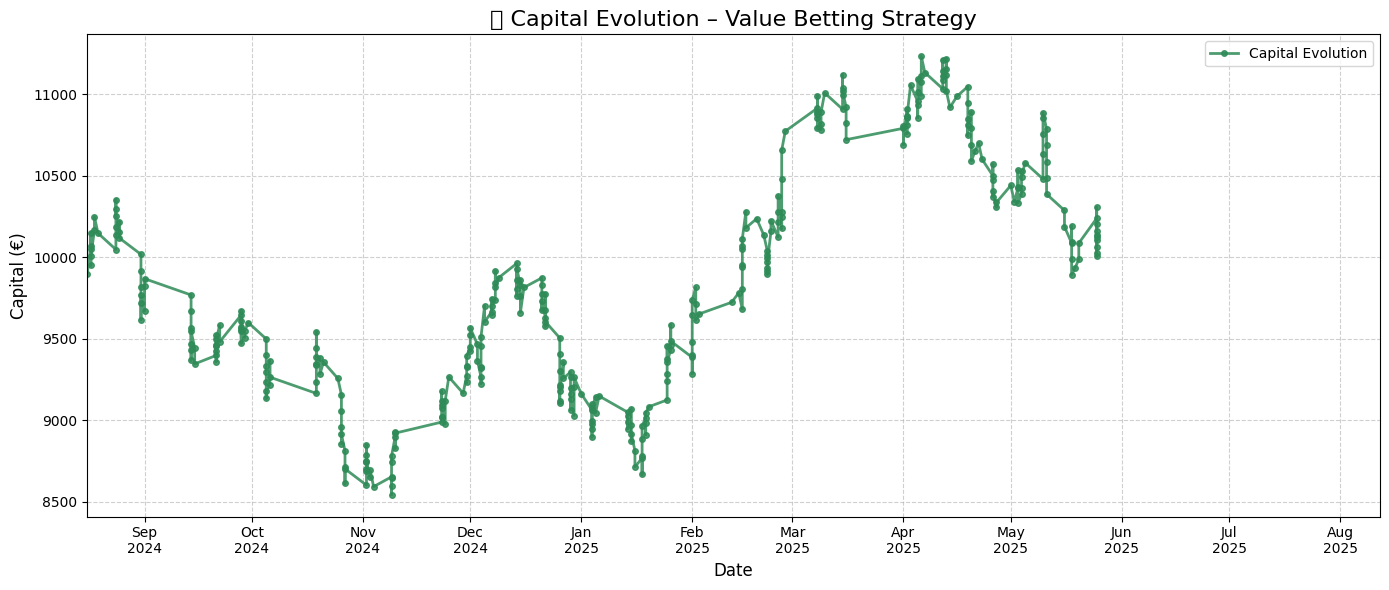

In [12]:
# 6. plot capital evolution

start_date = merged_df[merged_df['PlacedBet']]['Date'].min()

plt.figure(figsize=(14, 6))
plt.plot(merged_df['Date'], merged_df['Capital'],
         label='Capital Evolution',
         color='seagreen', linewidth=2, marker='o', markersize=4, alpha=0.85)

plt.title("📈 Capital Evolution – Value Betting Strategy", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Capital (€)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlim(left=start_date)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
plt.xticks(rotation=0)
plt.tight_layout()
plt.legend()
plt.show()

### Let's improve the results 
We will filter bets with expected value, If EV>1: the bet has positive expected value (value bet), and then we define the best EV thershold. 

In [13]:
# 1. Load and merge data

test_df = pd.read_csv('walk_forward_test_set.csv')
odds_df = pd.read_csv('24-25.csv')

test_df['Date'] = pd.to_datetime(test_df['Date'], errors='coerce')
odds_df['Date'] = pd.to_datetime(odds_df['Date'], dayfirst=True, errors='coerce')

odds_df.rename(columns={'Avg>2.5': 'Odds_Over2.5', 'Avg<2.5': 'Odds_Under2.5'}, inplace=True)

merged_df = pd.merge(
    test_df,
    odds_df[['Date', 'HomeTeam', 'AwayTeam', 'Odds_Over2.5', 'Odds_Under2.5']],
    on=['Date', 'HomeTeam', 'AwayTeam'],
    how='left'
)


# 2. Remove duplicate games

merged_df = merged_df.drop_duplicates(subset=['Date', 'HomeTeam', 'AwayTeam'], keep='first')

In [14]:
# 3. Value betting strategy with multiple EV thresholds

stake = 100
initial_capital = 10000
ev_thresholds = [1.00, 1.05, 1.10, 1.15, 1.20, 1.25, 1.50, 1.60]

def decide_bet_ev(row, threshold):
    if pd.isna(row['Odds_Over2.5']) or pd.isna(row['Odds_Under2.5']):
        return 'No Bet'
    ev_over = row['ProbOver25'] * row['Odds_Over2.5']
    ev_under = (1 - row['ProbOver25']) * row['Odds_Under2.5']
    if ev_over > threshold and ev_over > ev_under:
        return 'Over'
    elif ev_under > threshold and ev_under > ev_over:
        return 'Under'
    else:
        return 'No Bet'

def calculate_profit(row):
    if row['Bet'] == 'Over':
        return (row['Odds_Over2.5'] - 1) * stake if row['TrueLabel'] == 1 else -stake
    elif row['Bet'] == 'Under':
        return (row['Odds_Under2.5'] - 1) * stake if row['TrueLabel'] == 0 else -stake
    return 0

results = []

for threshold in ev_thresholds:
    df = merged_df.copy()
    df['Bet'] = df.apply(lambda row: decide_bet_ev(row, threshold), axis=1)
    df['Profit'] = df.apply(calculate_profit, axis=1)
    df['Capital'] = initial_capital + df['Profit'].cumsum()
    df['PlacedBet'] = df['Bet'] != 'No Bet'

    placed_bets = df[df['PlacedBet']]
    correct_bets = placed_bets[((placed_bets['Bet'] == 'Over') & (placed_bets['TrueLabel'] == 1)) |
                               ((placed_bets['Bet'] == 'Under') & (placed_bets['TrueLabel'] == 0))]
    hit_rate = round(len(correct_bets) / len(placed_bets) * 100, 2) if len(placed_bets) > 0 else 0
    total_profit = df['Profit'].sum()
    roi = round((total_profit / (len(placed_bets) * stake)) * 100, 2) if len(placed_bets) > 0 else 0
    final_cap = df['Capital'].iloc[-1]

    results.append({
    'EV Threshold': threshold,
    'Bets Placed': int(len(placed_bets)),  # ← força inteiro
    'Total Profit (€)': round(total_profit, 2),
    'ROI (%)': roi,
    'Hit Rate (%)': hit_rate,
    'Final Capital (€)': round(final_cap, 2)
 })


summary_df = pd.DataFrame(results)
best = summary_df.sort_values(by='ROI (%)', ascending=False).iloc[0]
best_threshold = best['EV Threshold']

In [19]:
# 4. Find best EV threshold and print clean summary

summary_df = pd.DataFrame(results)
best = summary_df.sort_values(by='ROI (%)', ascending=False).iloc[0]
best_threshold = best['EV Threshold']

 
print("\nBetting Strategy Summary (Best EV Threshold):\n")
print(f"Bets placed: {int(best['Bets Placed'])}")
print(f"Total profit (€): {best['Total Profit (€)']:.2f}")
print(f"ROI (%): {best['ROI (%)']:.2f}")
print(f"Hit rate (%): {best['Hit Rate (%)']:.2f}")
print(f"Final capital (€): {best['Final Capital (€)']:.2f}")


Betting Strategy Summary (Best EV Threshold):

Bets placed: 92
Total profit (€): 546.00
ROI (%): 5.93
Hit rate (%): 50.00
Final capital (€): 10546.00


C:\Users\Utilizador\AppData\Local\Temp\ipykernel_86176\1264731740.py:24: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Utilizador\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


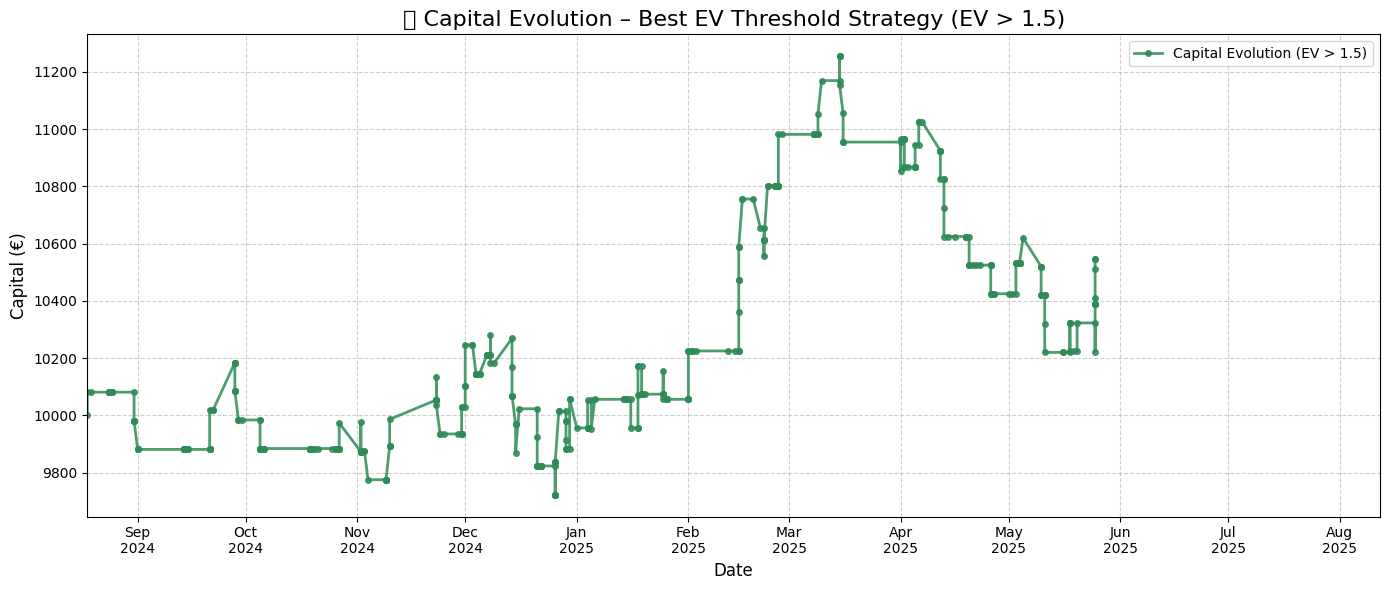

In [17]:
# 5. Plot capital evolution for the best EV threshold

final_df = merged_df.copy()
final_df['Bet'] = final_df.apply(lambda row: decide_bet_ev(row, best_threshold), axis=1)
final_df['Profit'] = final_df.apply(calculate_profit, axis=1)
final_df['Capital'] = initial_capital + final_df['Profit'].cumsum()
final_df['PlacedBet'] = final_df['Bet'] != 'No Bet'

start_date = final_df[final_df['PlacedBet']]['Date'].min()

plt.figure(figsize=(14, 6))
plt.plot(final_df['Date'], final_df['Capital'],
         label=f'Capital Evolution (EV > {best_threshold})',
         color='seagreen', linewidth=2, marker='o', markersize=4, alpha=0.85)

plt.title(f"📈 Capital Evolution – Best EV Threshold Strategy (EV > {best_threshold})", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Capital (€)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlim(left=start_date)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
plt.xticks(rotation=0)
plt.tight_layout()
plt.legend()
plt.show()

### Evaluation
This strategy as better results, the model gains with the expected value filter of > 1.5 on the bets to take.